In [1]:
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272448 sha256=d4e3a9f4754683e45d971e2772790144eaef9829c0a573eb5fe2104778dbf846
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
!cp ../input/torchdetection/* .

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#my imports
import pydicom as dicom
import pickle
import matplotlib as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import PIL
from PIL import Image, ImageDraw

import torch
import transforms as T
import torchvision.transforms as T2
import utils
import torchvision
import tqdm


import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
transform = []
transform.append(T2.ToTensor())
transform = T2.Compose(transform)

In [6]:
model = torch.load("../input/private-model-save-dataset/model-save-5.pkl")
model.to(device)
model.eval()
image_path = '../input/vinbigdata-chest-xray-abnormalities-detection/train/0032c6091dc8f1b1245fc2f5f45458fa.dicom'
ds = dicom.read_file(image_path)

img = ds.pixel_array.astype('float32')
dimg = ds.pixel_array.astype('float32')

if ds.PhotometricInterpretation=='MONOCHROME1':
    img=np.amax(img)-img
    dimg = np.amax(dimg)-dimg
img = img/np.max(img)
dimg = dimg/np.max(dimg)
img = transform(img)
img = img.to(device)
# model = model.to(device)
img.unsqueeze_(0)
# img = img.view(1, 3, 32, 32)
predictions = model(img)

In [7]:
boxes = predictions[0]['boxes']
boxes

tensor([[1254.5287,  229.4641, 1762.5942,  428.4822],
        [ 783.0709, 1367.2008, 1843.9535, 1764.5006]], device='cuda:0',
       grad_fn=<StackBackward>)

In [8]:
labels = predictions[0]['labels']
labels

tensor([12,  4], device='cuda:0')

In [9]:
scores = predictions[0]['scores']
scores

tensor([0.7451, 0.7344], device='cuda:0', grad_fn=<IndexBackward>)

In [10]:
boxes[0], labels[0].item(), scores[0].item()

(tensor([1254.5287,  229.4641, 1762.5942,  428.4822], device='cuda:0',
        grad_fn=<SelectBackward>),
 12,
 0.7451314330101013)

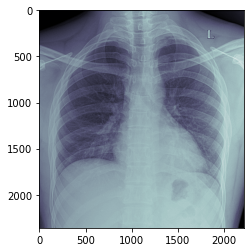

In [11]:
plt.pyplot.imshow(dimg,cmap='bone')

In [12]:
submissions = pd.DataFrame(columns=['image_id', 'PredictionString'])

In [13]:
for filename in os.listdir("../input/vinbigdata-chest-xray-abnormalities-detection/test"):
#     print("../input/vinbigdata-chest-xray-abnormalities-detection/test/"+filename)
    image_path = "../input/vinbigdata-chest-xray-abnormalities-detection/test/"+filename
    submissions.loc[len(submissions)] = [filename[:-6], ""]
    ds = dicom.read_file(image_path)

    img = ds.pixel_array.astype('float32')
    dimg = ds.pixel_array.astype('float32')

    if ds.PhotometricInterpretation=='MONOCHROME1':
        img=np.amax(img)-img
        dimg = np.amax(dimg)-dimg
    img = img/np.max(img)
    dimg = dimg/np.max(dimg)
    img = transform(img)
    img = img.to(device)
    # model = model.to(device)
    img.unsqueeze_(0)
    # img = img.view(1, 3, 32, 32)
    predictions = model(img)
    predictions = predictions[0]
    
#     print(predictions)
    for i in range(len(predictions['scores'])):
        if (predictions['scores'][i]>0.98):
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['labels'][i].item()-1)+" "
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['scores'][i].item())+" "
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['boxes'][i][0].item())+" "
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['boxes'][i][1].item())+" "
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['boxes'][i][2].item())+" "
            submissions.iat[len(submissions)-1, 1]=submissions.iat[len(submissions)-1, 1]+str(predictions['boxes'][i][3].item())+" "
#             print(str(predictions['labels'][i].item()))
        else:
            break
    if (submissions.iat[len(submissions)-1, 1]==""):
        submissions.iat[len(submissions)-1, 1]="14 1 0 0 1 1"

In [14]:
submissions.to_csv("./submissions.csv", index=False)